In [6]:
from collections import defaultdict
from metavision_core.event_io import RawReader
from hyperscope import config
from metavision_ml.preprocessing import timesurface
from metavision_sdk_core import RoiFilterAlgorithm, FlipXAlgorithm, PolarityFilterAlgorithm
from metavision_sdk_base import EventCDBuffer
from metavision_sdk_cv import (
    RotateEventsAlgorithm,
    SpatioTemporalContrastAlgorithm,
    SparseOpticalFlowAlgorithm,
    AntiFlickerAlgorithm,
    TrailFilterAlgorithm,
)
from math import pi
import gc
import h5py


class ProcessingPipeline:
    algorithms = []
    bufs = [None]

    def __init__(self, *algorithms):
        for algorithm in algorithms:
            self.append(algorithm)

    def append(self, algorithm):
        self.algorithms.append(algorithm)
        self.bufs.insert(-1, algorithm.get_empty_output_buffer())

    def insert(self, i, algorithm):
        self.algorithms.insert(i, algorithm)
        if i >= len(self.bufs):
            i = -1  # keep None as the last item
        self.bufs.insert(i, algorithm.get_empty_output_buffer())

    def process_events(self, evts):
        current_buf = evts
        next_buf = self.bufs[0]

        for i, a in enumerate(self.algorithms):
            a.process_events(current_buf, next_buf)
            current_buf = next_buf
            next_buf = self.bufs[i + 1]

        return self.bufs[-2].numpy(copy=True)


def transform_roi_90deg_ccw(x0, y0, x1, y1, image_height):
    new_x0 = image_height - y1
    new_y0 = x0
    new_x1 = image_height - y0
    new_y1 = x1
    return new_x0, new_y0, new_x1, new_y1


raw_file_path = str(config.DATA_DIR / "raw" / "metavision" / "recording_2024-07-30_13-51-19.raw")
reader = RawReader(raw_file_path)
height, width = reader.get_size()

x1, y1, x2, y2 = 265, 100, 430, 400
polarity_filter = PolarityFilterAlgorithm(polarity=1)  # only positive events
trail_filter = TrailFilterAlgorithm(height, width, 10)
anti_flicker_filter = AntiFlickerAlgorithm(height, width)
rot_algo = RotateEventsAlgorithm(height - 1, width - 1, -pi / 2)
flip_x_algo = FlipXAlgorithm(x2 - x1 - 1)
roi_filter = RoiFilterAlgorithm(
    *transform_roi_90deg_ccw(x1, y1, x2, y2, height), output_relative_coordinates=True
)


pipeline = ProcessingPipeline(
    polarity_filter, trail_filter, anti_flicker_filter, rot_algo, roi_filter
)

# polarity_buf = polarity_filter.get_empty_output_buffer()
# rot_buf = rot_algo.get_empty_output_buffer()
# flip_x_buf = flip_x_algo.get_empty_output_buffer()
# roi_buf = roi_filter.get_empty_output_buffer()
# events_buf = trail_filter_algorithm.get_empty_output_buffer()
# events_buf_2 = anti_flicker_filter.get_empty_output_buffer()


# def filter_events(evs):
#     polarity_filter.process_events(evs, polarity_buf)
#     trail_filter_algorithm.process_events(flip_x_buf, events_buf)
#     anti_flicker_filter.process_events(events_buf, roi_buf)
#     roi_filter.process_events(roi_buf, events_buf_2)
#     flip_x_algo.process_events(rot_buf, flip_x_buf)
#     rot_algo.process_events(polarity_buf, rot_buf)


start_time = int(25e6)
duration = int(2e6)  # capture 2s
stop_time = start_time + duration
accumulation_time = 10  # 10us
dt = 100_000  # batch length in us
exposure_time = 10_000  # exposure time of cmos in us
bins = duration // accumulation_time  # how many 10us bins in total duration
batches = duration // dt  # how many batches we need to process the total duration

from tqdm import tqdm

# Seek to
reader.reset()
reader.seek_time(start_time)
reader.clear_ext_trigger_events()  # not interested in earlier triggers
x0, y0, x1, y1 = transform_roi_90deg_ccw(x1, y1, x2, y2, height)
h = y1 - y0
w = x1 - x0

t_0 = None

buffer = []
pivot_ts = None

while not reader.is_done() and reader.current_time < stop_time:
    reader.load_delta_t(dt)

ext_evts = reader.get_ext_trigger_events()
ext_evts = ext_evts[ext_evts["p"] == 1]
reader.reset()
reader.seek_time(start_time)

ordered_pairs = []

v = np.zeros((exposure_time // accumulation_time, 1, h + 1, w + 1), dtype=np.float32)
with h5py.File("timesurfaces.h5", mode="w") as f:
    # Create extensible datasets
    timesurfaces_dataset = f.create_dataset(
        "timesurfaces",
        shape=(0, *v.shape),
        maxshape=(None, *v.shape),
        dtype=np.float32,
        chunks=(1, *v.shape),  # Each chunk is one timesurface
    )
    timestamps_dataset = f.create_dataset(
        "timestamps",
        shape=(0,),
        maxshape=(None,),
        dtype=np.int64,
        chunks=(1000,),  # Adjust chunk size as needed
    )

    for e in tqdm(ext_evts, desc="Aligning CMOS Exposures"):
        if reader.is_done():
            break
        reader.seek_time(e["t"] - exposure_time // 2)
        evts = reader.load_delta_t(exposure_time)
        # filter_events(evts)
        evts = pipeline.process_events(evts)
        if len(evts) == 0:
            continue  # Skip this timestamp if no events
        evts["t"] -= evts["t"][0]
        evts["p"] = 0
        timesurface(evts, v, exposure_time)

        # Extend datasets
        timesurfaces_dataset.resize(timesurfaces_dataset.shape[0] + 1, axis=0)
        timestamps_dataset.resize(timestamps_dataset.shape[0] + 1, axis=0)

        # Add new data
        timesurfaces_dataset[-1] = v
        timestamps_dataset[-1] = e["t"]

    f.attrs["exposure_time"] = exposure_time
    f.attrs["accumulation_time"] = accumulation_time

Aligning CMOS Exposures: 100%|██████████| 70/70 [04:07<00:00,  3.53s/it]


In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from skimage.morphology import binary_dilation, disk
from metavision_ml.preprocessing.viz import filter_outliers
import h5py
from skimage.filters import threshold_otsu
from skimage.measure import regionprops, label
from scipy.optimize import linear_sum_assignment
from filterpy.kalman import KalmanFilter
from collections import defaultdict
from scipy.interpolate import interp1d


class InterpolatedTrack:
    def __init__(self, initial_pos, initial_vel, initial_time, interpolation_points=100):
        self.kf = KalmanFilter(dim_x=4, dim_z=4)
        self.kf.x = np.array([initial_pos[0], initial_pos[1], initial_vel[0], initial_vel[1]]).reshape(4, 1)
        self.kf.F = np.array([[1, 0, 1, 0],
                              [0, 1, 0, 1],
                              [0, 0, 1, 0],
                              [0, 0, 0, 1]])
        self.kf.H = np.eye(4)
        self.kf.P *= 1000.
        self.kf.R *= 0.1
        self.kf.Q *= 0.1
        
        self.positions = [initial_pos]
        self.velocities = [initial_vel]
        self.times = [initial_time]
        self.interpolation_points = interpolation_points
        
    def predict(self):
        self.kf.predict()
        return self.kf.x.flatten()
    
    def update(self, measurement, time):
        self.kf.update(measurement)
        self.positions.append(self.kf.x[:2].flatten())
        self.velocities.append(self.kf.x[2:].flatten())
        self.times.append(time)
        
    def get_interpolated_track(self):
        if len(self.times) < 2:
            return np.array(self.positions), np.array(self.times)
        
        interp_times = np.linspace(self.times[0], self.times[-1], self.interpolation_points)
        interp_x = interp1d(self.times, [p[0] for p in self.positions], kind='linear')(interp_times)
        interp_y = interp1d(self.times, [p[1] for p in self.positions], kind='linear')(interp_times)
        
        return np.column_stack((interp_x, interp_y)), interp_times

# Utility functions

def plot_all_v(file_path):
    """Plot the mean of all timesurfaces in the HDF5 file."""
    with h5py.File(file_path) as h5_file:
        img = np.mean(h5_file['timesurfaces'][0:100], axis=(0, 1, 2))
        plt.imshow(img)
        plt.show()
        plt.close()

def get_hdf5_size(file_path):
    """Get the number of timestamps in the HDF5 file."""
    with h5py.File(file_path, 'r') as h5_file:
        return len(h5_file['timestamps'])

def read_hdf5_datasets(file_path):
    """Generator to read timesurfaces and timestamps from HDF5 file."""
    with h5py.File(file_path, 'r') as h5_file:
        timesurfaces = h5_file['timesurfaces']
        timestamps = h5_file['timestamps']
        num_items = len(timestamps)

        for i in range(num_items):
            timesurface = timesurfaces[i]
            timestamp = timestamps[i]
            yield timesurface, timestamp

def compute_optical_flow(time_surface):
    """Compute optical flow using gradient of time surface."""
    grad_y, grad_x = np.gradient(time_surface)
    np.nan_to_num(grad_x, False)
    np.nan_to_num(grad_y, False)
    return grad_x, grad_y

def find_centroids(image):
    """Find centroids of objects in the image using Otsu's thresholding."""
    thresh = threshold_otsu(image)
    binary = image > thresh
    footprint = disk(radius=3)
    binary = binary_dilation(binary, footprint)
    labeled = label(binary)

    regions = regionprops(labeled)
    centroids = np.array([region.centroid for region in regions if region.perimeter > 50])

    return centroids

def hungarian_matching(tracks, detections, max_distance=50):
    """Perform Hungarian matching between tracks and detections."""
    cost_matrix = np.zeros((len(tracks), len(detections)))
    for i, track in enumerate(tracks):
        for j, detection in enumerate(detections):
            cost_matrix[i, j] = np.linalg.norm(track.predict()[:2] - detection[:2])  # Only consider position for matching
    
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    matches = []
    unmatched_tracks = set(range(len(tracks)))
    unmatched_detections = set(range(len(detections)))
    
    for r, c in zip(row_ind, col_ind):
        if cost_matrix[r, c] > max_distance:
            continue
        matches.append((r, c))
        unmatched_tracks.remove(r)
        unmatched_detections.remove(c)
    
    return matches, list(unmatched_tracks), list(unmatched_detections)


def process_timesurfaces(file_path, subset_size=10, total_duration=10000, max_unmatched_frames=5, interpolation_points=100):
    """Process timesurfaces, perform tracking, and return interpolated positions, velocities, and times."""
    tracks = []
    interpolated_positions = []
    interpolated_times = []
    half_duration = total_duration // 2
    subset_duration = total_duration // subset_size
    unmatched_count = defaultdict(int)

    for v, t in tqdm(read_hdf5_datasets(file_path), total=get_hdf5_size(file_path), desc="Processing timesurfaces"):
        for i in range(0, len(v), subset_size):
            v_ = v[i:i+subset_size]
            mean_v = np.sum(v_, axis=(0, 1))
            if mean_v.max() == 0:
                continue
            mean_v = mean_v / mean_v.max()
            mean_v = mean_v[250:, 75:]
            mean_v = filter_outliers(mean_v, 2)
            
            flow_x, flow_y = compute_optical_flow(mean_v)
            flow_mag = np.sqrt(flow_x**2 + flow_y**2)
            try:
                centroids = find_centroids(flow_mag)
            except Exception as e:
                print(f"Exception occurred: {e}")
                continue
            
            current_time = t - half_duration + i * subset_duration + subset_duration // 2
            
            if len(centroids) > 0:
                centroid_velocities = [(flow_x[int(c[0]), int(c[1])], flow_y[int(c[0]), int(c[1])]) for c in centroids]
                
                if not tracks:
                    tracks = [InterpolatedTrack(centroid, velocity, current_time, interpolation_points) 
                              for centroid, velocity in zip(centroids, centroid_velocities)]
                else:
                    predicted_states = [track.predict() for track in tracks]
                    matches, unmatched_tracks, unmatched_detections = hungarian_matching(tracks, centroids)
                    
                    # Reset unmatched count for all tracks
                    unmatched_count = defaultdict(int)
                    
                    for track_idx, detection_idx in matches:
                        measurement = np.array([centroids[detection_idx][0], 
                                                centroids[detection_idx][1], 
                                                centroid_velocities[detection_idx][0],
                                                centroid_velocities[detection_idx][1]])
                        tracks[track_idx].update(measurement, current_time)
                    
                    for idx in unmatched_detections:
                        new_track = InterpolatedTrack(centroids[idx], centroid_velocities[idx], current_time, interpolation_points)
                        tracks.append(new_track)
                    
                    for idx in unmatched_tracks:
                        unmatched_count[idx] += 1
                    
                    # Remove tracks that have been unmatched for too long
                    tracks = [track for idx, track in enumerate(tracks) if unmatched_count[idx] < max_unmatched_frames]
            
            # Interpolate and store tracks
            for track in tracks:
                interp_positions, interp_times = track.get_interpolated_track()
                interpolated_positions.append(interp_positions)
                interpolated_times.append(interp_times)

    return np.array(interpolated_positions), np.array(interpolated_times)

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_3d_centroids(positions, times, ext_times, sample_rate=1, time_tolerance=1000, start_time=None, end_time=None):
    """
    Create a 3D scatter plot of centroid positions over time with planes at specific times,
    restricted to a specific time range if specified.
    
    :param positions: List of numpy arrays, each containing x, y coordinates for tracks
    :param times: List of numpy arrays, each containing time values for tracks
    :param ext_times: List or array of times at which to add planes
    :param sample_rate: Integer, plot every nth point to reduce density (default: 1, plot all points)
    :param time_tolerance: Float, tolerance for finding points near the planes (default: 1000)
    :param start_time: Float, start of the time range to plot (default: None, plot from the beginning)
    :param end_time: Float, end of the time range to plot (default: None, plot until the end)
    """
    # Flatten positions and times arrays
    flat_positions = np.concatenate(positions)
    flat_times = np.concatenate(times)
    
    # Ensure ext_times is a numpy array
    ext_times = np.array(ext_times)
    
    # Sample the data to reduce density if needed
    flat_positions = flat_positions[::sample_rate]
    flat_times = flat_times[::sample_rate]
    
    # Filter the data based on the specified time range
    if start_time is not None or end_time is not None:
        start_time = start_time if start_time is not None else np.min(flat_times)
        end_time = end_time if end_time is not None else np.max(flat_times)
        time_mask = (flat_times >= start_time) & (flat_times <= end_time)
        flat_positions = flat_positions[time_mask]
        flat_times = flat_times[time_mask]
        ext_times = ext_times[(ext_times >= start_time) & (ext_times <= end_time)]
    
    # Create the 3D plot
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    print(f"Time range: {np.min(flat_times)} to {np.max(flat_times)}")
    
    # Plot the scatter plot
    scatter = ax.scatter(flat_positions[:, 0], flat_positions[:, 1], flat_times, 
                         c=flat_times, cmap='viridis', 
                         s=10, alpha=0.6, label='Centroids')
    
    # Prepare for planes
    x_min, x_max = flat_positions[:, 0].min(), flat_positions[:, 0].max()
    y_min, y_max = flat_positions[:, 1].min(), flat_positions[:, 1].max()
    X, Y = np.meshgrid(np.linspace(x_min, x_max, 10), np.linspace(y_min, y_max, 10))
    
    # Plot the planes
    for ext_time in ext_times:
        Z = np.full_like(X, ext_time)
        ax.plot_surface(X, Y, Z, alpha=0.2, color='red')
    
    # Set labels and title
    ax.set_xlabel('X position')
    ax.set_ylabel('Y position')
    ax.set_zlabel('Time')
    ax.set_title(f'Centroid Positions Over Time ({start_time} to {end_time})')
    
    # Add a color bar
    cbar = fig.colorbar(scatter, ax=ax, label='Time')
    
    # Add legend
    ax.legend()
    
    # Show the plot
    plt.show()

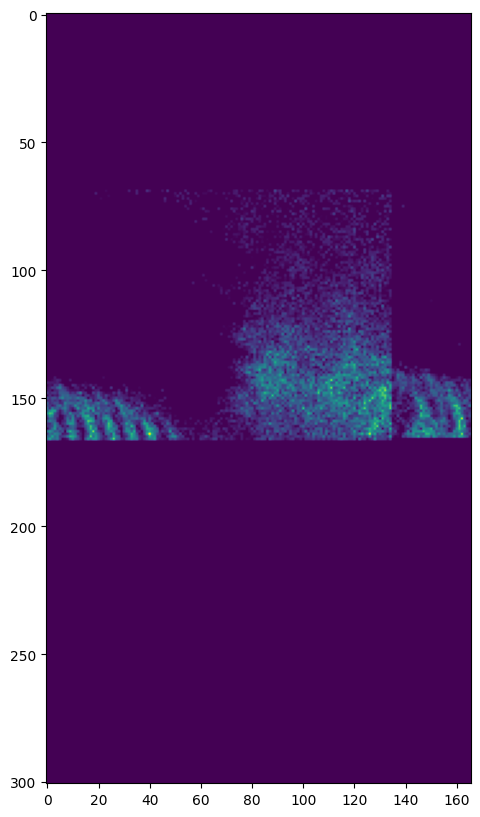

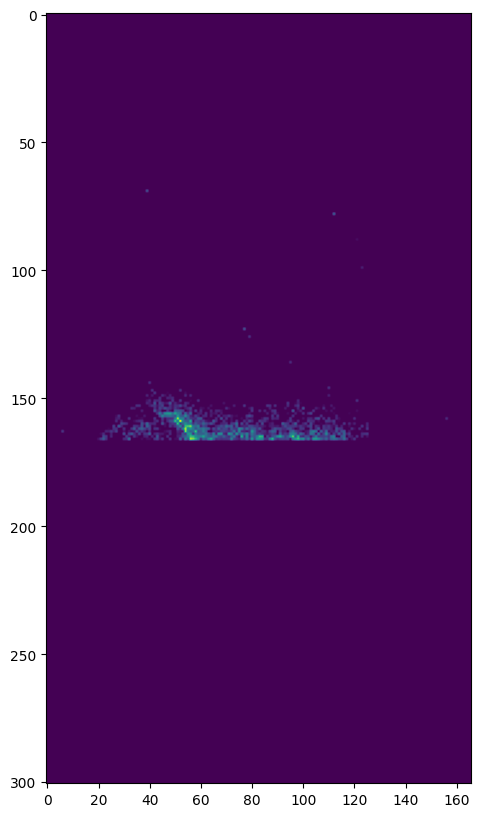

Help on class RoiFilterAlgorithm in module metavision_sdk_core:

class RoiFilterAlgorithm(pybind11_builtins.pybind11_object)
 |  Class that only propagates events which are contained in a certain
 |  Region of Interest (ROI) defined by the coordinates of the upper left
 |  corner and the lower right corner.
 |  
 |  Method resolution order:
 |      RoiFilterAlgorithm
 |      pybind11_builtins.pybind11_object
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(...)
 |      __init__(self: metavision_sdk_core.RoiFilterAlgorithm, x0: int, y0: int, x1: int, y1: int, output_relative_coordinates: bool = False) -> None
 |      
 |      Builds a new RoiFilterAlgorithm object which propagates events in the
 |      given window.
 |      
 |         :x0: X coordinate of the upper left corner of the ROI window
 |         :y0: Y coordinate of the upper left corner of the ROI window
 |         :x1: X coordinate of the lower right corner of the ROI window
 |         :y1: Y coordin

KeyboardInterrupt: 

<Figure size 1000x1000 with 0 Axes>

In [3]:
#plot_all_v('timesurfaces.h5')

# positions, times = process_timesurfaces('timesurfaces.h5', subset_size=100)
import h5py
with h5py.File('timesurfaces.h5', mode='r') as f:
    for i in range(0, len(f['timesurfaces']), 10):
        plt.figure(figsize=(10, 10))
        ts = f['timesurfaces'][i:i+10]
        ts = np.mean(ts, axis=(0, 1, 2))
        plt.imshow(ts)
        plt.show()
#     plot_3d_centroids(positions=positions, times=times, ext_times=f['timestamps'])